### IMPORTS

In [2]:
import glob
import os.path
import numpy as np
import sys
import codecs
import json
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from xgboost import XGBClassifier
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

### DATA LOAD

In [3]:
train_folder = "datasets/train-articles" # check that the path to the datasets folder is correct, 
dev_folder = "datasets/dev-articles"     # if not adjust these variables accordingly
train_labels_file = "datasets/train-task2-TC.labels"
dev_template_labels_file = "datasets/dev-task-TC-template.out"
task_TC_output_file = "baseline-output-TC.txt"

def read_articles_from_file_list(folder_name, file_pattern="*.txt"):
    """
    Read articles from files matching patterns <file_pattern> from  
    the directory <folder_name>. 
    The content of the article is saved in the dictionary whose key
    is the id of the article (extracted from the file name).
    Each element of <sentence_list> is one line of the article.
    """
    file_list = glob.glob(os.path.join(folder_name, file_pattern))
    articles = {}
    article_id_list, sentence_id_list, sentence_list = ([], [], [])
    for filename in sorted(file_list):
        article_id = os.path.basename(filename).split(".")[0][7:]
        with codecs.open(filename, "r", encoding="utf8") as f:
            articles[article_id] = f.read()
    return articles


def read_predictions_from_file(filename):
    """
    Reader for the gold file and the template output file. 
    Return values are four arrays with article ids, labels 
    (or ? in the case of a template file), begin of a fragment, 
    end of a fragment. 
    """
    articles_id, span_starts, span_ends, gold_labels = ([], [], [], [])
    with open(filename, "r") as f:
        for row in f.readlines():
            article_id, gold_label, span_start, span_end = row.rstrip().split("\t")
            articles_id.append(article_id)
            gold_labels.append(gold_label)
            span_starts.append(span_start)
            span_ends.append(span_end)
    return articles_id, span_starts, span_ends, gold_labels

def compute_features_b(articles, span_starts, span_ends):
    # only one feature, the length of the span
    return np.array([ int(sp_ends)-int(sp_starts) for sp_starts, sp_ends in zip(span_starts, span_ends) ]).reshape(-1, 1)

def clean(text):
    text=text.lower()
    text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    text=re.sub('[“"”]',' " ',text)
    retain='[^abcdefghijklmnopqrstuvwxyz!#?" ]'
    text=re.sub('[()–-]',' ',text)
    text=re.sub(retain,'',text)
    text=text.replace('?',' ? ')
    text=text.replace('#',' # ')
    text=text.replace('!',' ! ')
    return ' '.join(text.split())

# loading articles' content from *.txt files in the train folder
articles = read_articles_from_file_list(train_folder)
dev_articles = read_articles_from_file_list(dev_folder)

def read_span(id,span,dev=False):
    if dev:
        return dev_articles[id][span[0]:span[1]]
    else:
        return articles[id][span[0]:span[1]]
    
def wordListToFreqDict(wordlist):
    freq=dict()
    for word in wordlist:
        if word in freq:
            freq[word]+=1
        else:
            freq[word]=1
    return freq
def sortFreqDict(freqdict):
    aux = [(freqdict[key], key) for key in freqdict]
    aux.sort()
    aux.reverse()
    return aux
def compute_feature(sentence,tfilf):
    feat=[]
    for prop in Propagandas:
        val=0
        for tok in sentence.split():
            if tok in tfilf[prop]:
                val=val+tfilf[prop][tok]
        feat.append(val)     
    return feat

In [4]:
# loading gold labels, articles ids and sentence ids from files *.task-TC.labels in the train labels folder 
ref_articles_id, ref_span_starts, ref_span_ends, train_gold_labels = read_predictions_from_file(train_labels_file)
print("Loaded %d annotations from %d articles" % (len(ref_span_starts), len(set(ref_articles_id))))

# reading data from the development set
dev_article_ids, dev_span_starts, dev_span_ends, dev_labels = read_predictions_from_file(dev_template_labels_file)

Loaded 6129 annotations from 357 articles


In [5]:
in_data=[(id, [int(sps),int(spe)])for id, sps, spe in zip(ref_articles_id, ref_span_starts, ref_span_ends)]
df=pd.DataFrame(in_data,columns=['ID','Span'])
df['Sentence']=[read_span(id,span) for id,span in zip(df['ID'].tolist(),df['Span'].tolist())]
df['Sentence']=df['Sentence'].apply(lambda x : clean(x))
df['Span']=df['Span'].apply(lambda x : x[1]-x[0])
df['Target']=train_gold_labels
df=df.drop_duplicates()

In [6]:
dev_data=[(id, [int(sps),int(spe)])for id, sps, spe in zip(dev_article_ids, dev_span_starts, dev_span_ends)]
df_dev=pd.DataFrame(dev_data,columns=['ID','Span'])
df_dev['Sentence']=[read_span(id,span,dev=True) for id,span in zip(df_dev['ID'].tolist(),df_dev['Span'].tolist())]
df_dev['Sentence']=df_dev['Sentence'].apply(lambda x : clean(x))
df_dev['Span']=df_dev['Span'].apply(lambda x : x[1]-x[0])

In [7]:
df.head()

,ID,Span,Sentence,Target
0,111111111,58,the next transmission could be more pronounced...,Appeal_to_Authority
1,111111111,140,when the plague comes again it starts from mor...,Appeal_to_Authority
2,111111111,8,appeared,Doubt
3,111111111,22,a very very different,Repetition
4,111111111,128,he also pointed to the presence of the pneumon...,Appeal_to_fear-prejudice


In [8]:
df_dev.head()

,ID,Span,Sentence
0,730093263,5,white
1,730093263,5,black
2,730093263,23,""" true american heroes """
3,730093263,5,black
4,730093263,108,if these two men had survived and quentin lama...


## BASELINE MODEL

In [9]:
X_train, X_test, Y_train, Y_test = train_test_split(df['Span'].values.reshape(-1,1), df['Target'].values.reshape(-1,1),test_size=500, stratify=df['Target'], random_state=1234)

In [10]:
base_model = LogisticRegression(penalty='l2', class_weight='balanced', solver="lbfgs")
base_model.fit(X_train, Y_train)
pred=base_model.predict(X_test)

/home/somesh/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/somesh/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


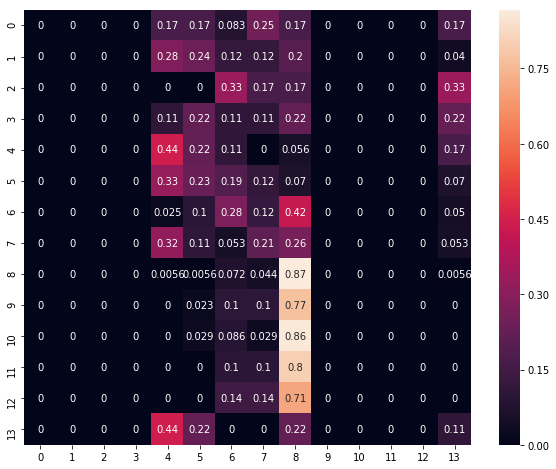

In [11]:
cm=confusion_matrix(Y_test,pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize = (10,8))
sns.heatmap(cm,annot=True)

In [12]:
print(classification_report(Y_test,pred))

                                    precision    recall  f1-score   support

               Appeal_to_Authority       0.00      0.00      0.00        12
          Appeal_to_fear-prejudice       0.00      0.00      0.00        25
    Bandwagon,Reductio_ad_hitlerum       0.00      0.00      0.00         6
           Black-and-White_Fallacy       0.00      0.00      0.00         9
         Causal_Oversimplification       0.18      0.44      0.26        18
                             Doubt       0.28      0.23      0.25        43
         Exaggeration,Minimisation       0.20      0.28      0.23        40
                       Flag-Waving       0.10      0.21      0.13        19
                   Loaded_Language       0.51      0.87      0.64       180
             Name_Calling,Labeling       0.00      0.00      0.00        87
                        Repetition       0.00      0.00      0.00        35
                           Slogans       0.00      0.00      0.00        10
       Thou

/home/somesh/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### TOPIC MODELLING

In [ ]:
train_corpus = open("dumps/Text_stitch.txt",'r').read()
train_corpus= clean(train_corpus)

In [ ]:
train_freq=wordListToFreqDict(train_corpus.split())
freq_sorted=sortFreqDict(train_freq)

In [ ]:
Propagandas=set(df['Target'])
Topic_freq=dict()
for prop in Propagandas:
    wl=(' '.join(df[df['Target']==prop]['Sentence'].tolist())).split(' ')
    Topic_freq[prop]=wordListToFreqDict(wl)

In [ ]:
wl=(' '.join(df['Sentence'].tolist())).split(' ')
freq=wordListToFreqDict(wl)

In [ ]:
tfilf=dict()
L=len(df)
c=0
for prop in Topic_freq:
    tfilf[prop]=dict()
    l=len(df[df['Target']==prop])
    for word in Topic_freq[prop]:
        if word in train_freq and freq[word]>85:
            num=Topic_freq[prop][word]/l
            den=(freq[word]-Topic_freq[prop][word])/(L-l)
            if den > 0 and num/den > 1 :
                tfilf[prop][word]=num/den

In [ ]:
Data=pd.DataFrame([compute_feature(sentence,tfilf) for sentence in df['Sentence'].tolist()])
Data=Data.join(df)
Data.dropna(inplace=True)
#Data.drop([1,5,7,13],axis=1,inplace=True)
Data.head()

In [ ]:
Data.describe()

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(Data.drop(['Sentence','ID','Target'],axis=1), Data['Target'], test_size=578, stratify=Data['Target'])
X_train, X_test = StandardScaler().fit_transform(X_train), StandardScaler().fit_transform(X_test)

In [ ]:
model = LogisticRegression(penalty='l2', class_weight='balanced', solver="liblinear", multi_class='ovr')
model.fit(X_train, Y_train)
pred=model.predict(X_train)

In [ ]:
cm=confusion_matrix(Y_train,pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize = (10,8))
sns.heatmap(cm,annot=True)

In [ ]:
print(classification_report(Y_train,pred))

##### writing predictions to file
with open(task_TC_output_file, "w") as fout:
    for article_id, prediction, span_start, span_end in zip(dev_article_ids, predictions, dev_span_starts, dev_span_ends):
        fout.write("%s\t%s\t%s\t%s\n" % (article_id, prediction, span_start, span_end))
print("Predictions written to file " + task_TC_output_file)

## TFIDF

In [85]:
from io import StringIO
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from imblearn.over_sampling import SMOTE 

In [97]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,ngram_range=(1, 2),stop_words='english')
features = tfidf.fit_transform(df.Sentence).toarray()
features = np.append(features,df['Span'].values.reshape(-1,1),axis=1)
X_train, X_test, Y_train, Y_test = train_test_split(features,df['Target'].values,test_size=500, stratify=df['Target'].values, random_state=1234)

In [98]:
model_lr=LogisticRegression(penalty='l2', class_weight='balanced', solver="liblinear", max_iter=500)
model_lr.fit(X_train,Y_train)
predz=model_lr.predict(X_test)

/home/somesh/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


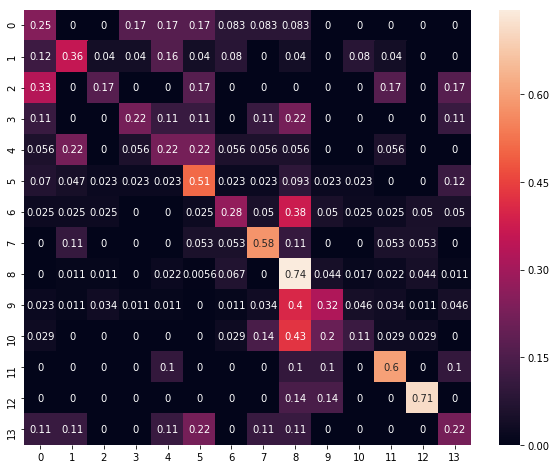

In [99]:
cm=confusion_matrix(Y_test,predz)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize = (10,8))
sns.heatmap(cm,annot=True)

In [100]:
print(classification_report(Y_test,predz))

                                    precision    recall  f1-score   support

               Appeal_to_Authority       0.17      0.25      0.20        12
          Appeal_to_fear-prejudice       0.41      0.36      0.38        25
    Bandwagon,Reductio_ad_hitlerum       0.11      0.17      0.13         6
           Black-and-White_Fallacy       0.25      0.22      0.24         9
         Causal_Oversimplification       0.21      0.22      0.22        18
                             Doubt       0.61      0.51      0.56        43
         Exaggeration,Minimisation       0.35      0.28      0.31        40
                       Flag-Waving       0.42      0.58      0.49        19
                   Loaded_Language       0.63      0.74      0.68       180
             Name_Calling,Labeling       0.58      0.32      0.41        87
                        Repetition       0.27      0.11      0.16        35
                           Slogans       0.32      0.60      0.41        10
       Thou